In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices("GPU"))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured with memory growth")
else:
    print("No GPU detected")

GPU configured with memory growth


In [6]:
(X_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
print("Data Shape", X_train.shape)

Data Shape (50000, 32, 32, 3)


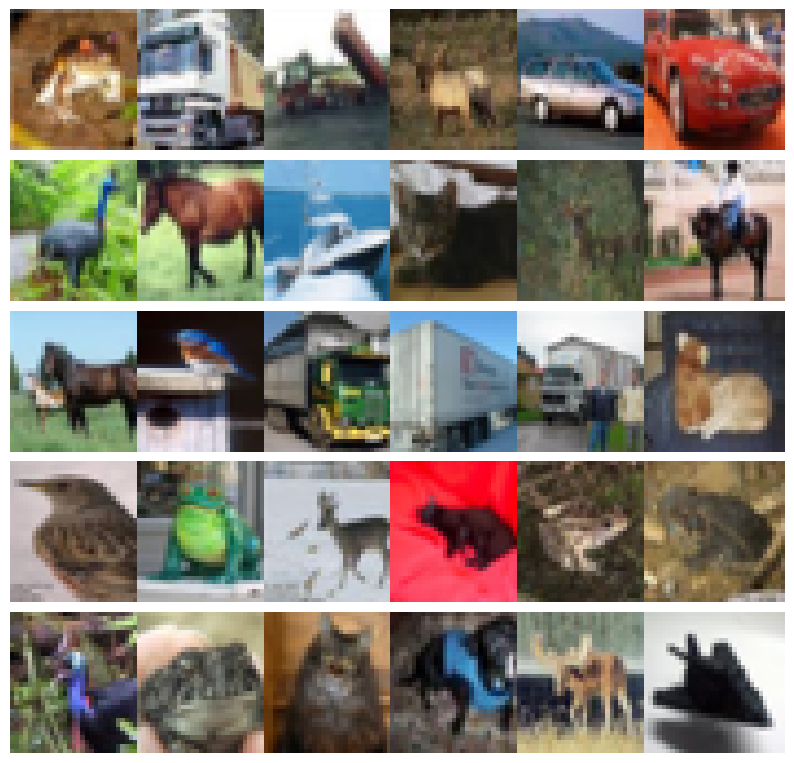

In [8]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# Data Pipeline

In [9]:
X_train.shape[0]

50000

In [10]:
# Normalize pixel values to [-1, 1] (GANs often work better with this range)
X_train = (X_train.astype('float32') - 127.5) / 127.5

In [11]:
# Batch and shuffle the data
BUFFER_SIZE = 50_000
BATCH_SIZE = 256
train_data = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

# Generator and Discriminator

In [13]:
def build_generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to (8, 8, 256)
    model.add(layers.Reshape((8, 8, 256)))

    # Upsample to (16, 16, 128)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to (32, 32, 64)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer: (32, 32, 3) for RGB images
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 3)           │           4,800 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

Architecture of our generator: We start with a dense layer, reshape it into a small grid, and use Conv2DTranspose layers to upsample to 32x32x3.

LeakyReLU: Helps with the gradient flow

BatchNormalization: Stabilizes training.



**Discriminator**

In [18]:
def build_discriminator():
    model = tf.keras.Sequential()

    # Input: (32, 32, 3) from our generator
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to (16, 16, 128)
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten and output a single value
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,985 (851.50 KB)

 Trainable params: 217,985 (851.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# loss function ad optimizers

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
# Building our sub ckass model
class GAN(keras.Model):
  def __init__(self, generator, discriminator):
    # initilize the GAN model  with the generator and discriminator
    super(GAN, self).__init__()
    self.generator = generator #set genrator model
    self.discriminator = discriminator # set discriminator moel


  def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer # set the generator optimizer
    self.d_optimizer = d_optimizer # set the discriminator optimizer
    self.g_loss = g_loss # set the generator loss
    self.d_loss = d_loss # set the discriminator loss


  def train_step(self, real_images):
    # Training logic
    batch_size = tf.shape(real_images)[0]

    # Train discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as d_tape:
        generated_images = self.generator(noise)
        real_output = self.discriminator(real_images)
        fake_output = self.discriminator(generated_images)
        d_loss = self.d_loss(real_output, fake_output)

    # Cimputing the gradients for the discriminator based in its loss
    d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

    # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}

In [25]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.seed = tf.random.normal([num_images, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5 #rescaleto range [0, 233]

      plt.figure(figsize=(10,10))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
      plt.show()

In [26]:
EPOCH = 100

gan = GAN(generator=generator, discriminator=discriminator)

gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - d_loss: 1.1837 - g_loss: 1.0520

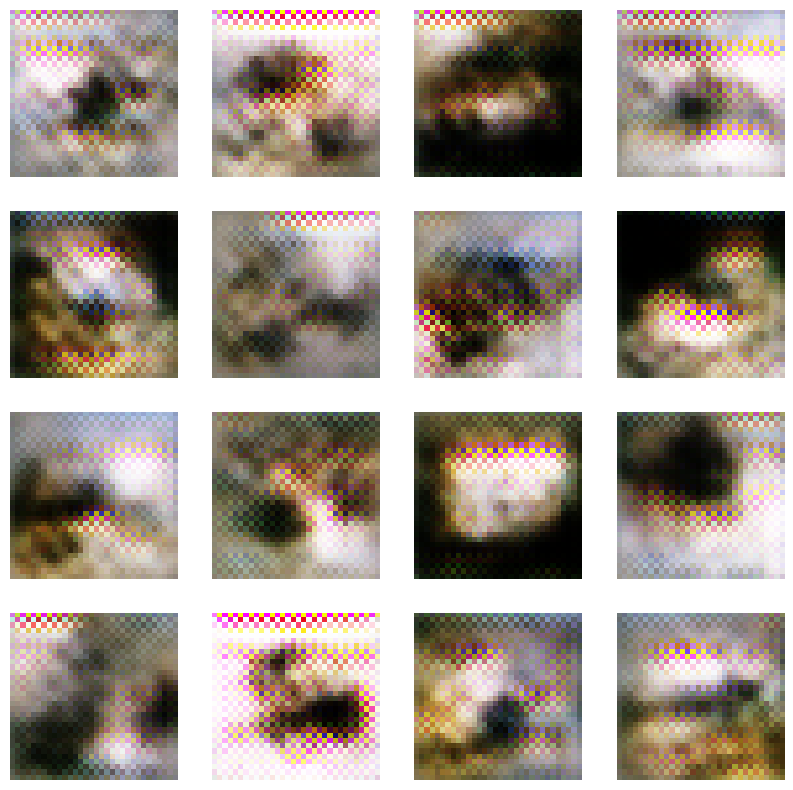

196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - d_loss: 1.1824 - g_loss: 1.0534
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - d_loss: 1.2626 - g_loss: 1.3778
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - d_loss: 1.1285 - g_loss: 1.4584
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - d_loss: 1.1292 - g_loss: 1.3913
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - d_loss: 1.2016 - g_loss: 0.9638
Epoch 6/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 1.2179 - g_loss: 1.0771

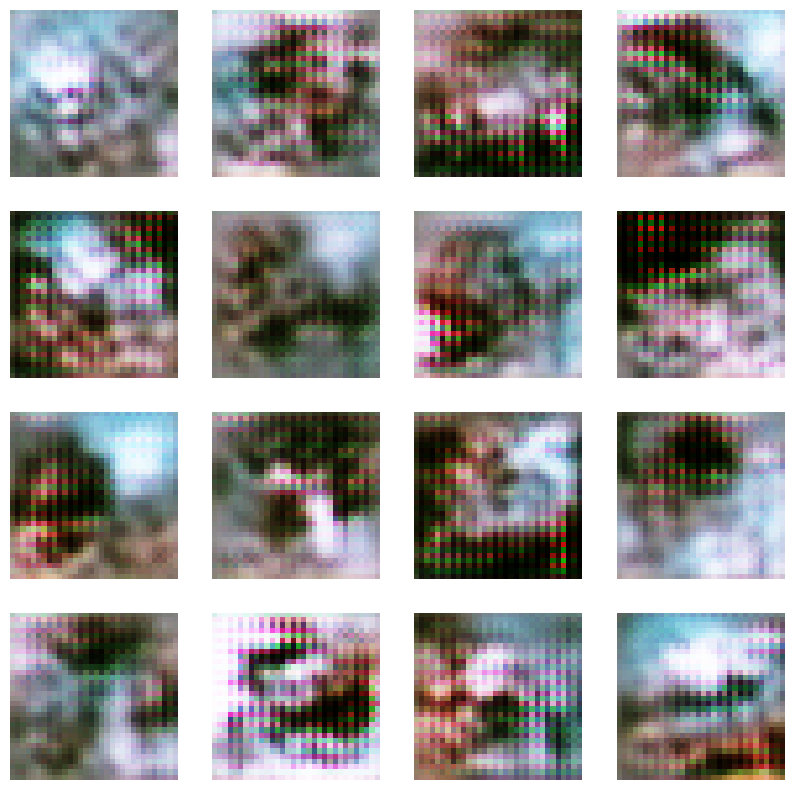

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2233 - g_loss: 1.0753
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - d_loss: 1.3131 - g_loss: 0.9814
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - d_loss: 1.2990 - g_loss: 1.4197
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - d_loss: 1.1044 - g_loss: 1.1936
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - d_loss: 1.2802 - g_loss: 0.8869
Epoch 11/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 1.1858 - g_loss: 0.9908

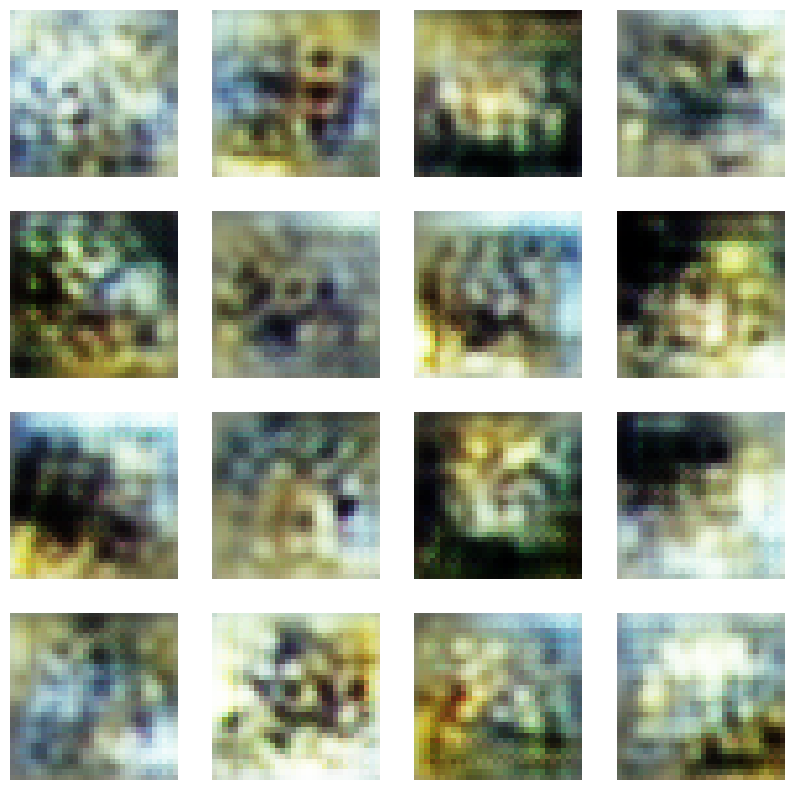

196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - d_loss: 1.1852 - g_loss: 0.9921
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - d_loss: 1.2351 - g_loss: 1.1241
Epoch 13/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - d_loss: 1.2385 - g_loss: 1.0448
Epoch 14/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - d_loss: 1.1522 - g_loss: 1.0850
Epoch 15/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - d_loss: 1.2433 - g_loss: 1.1994
Epoch 16/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 1.1626 - g_loss: 1.1090

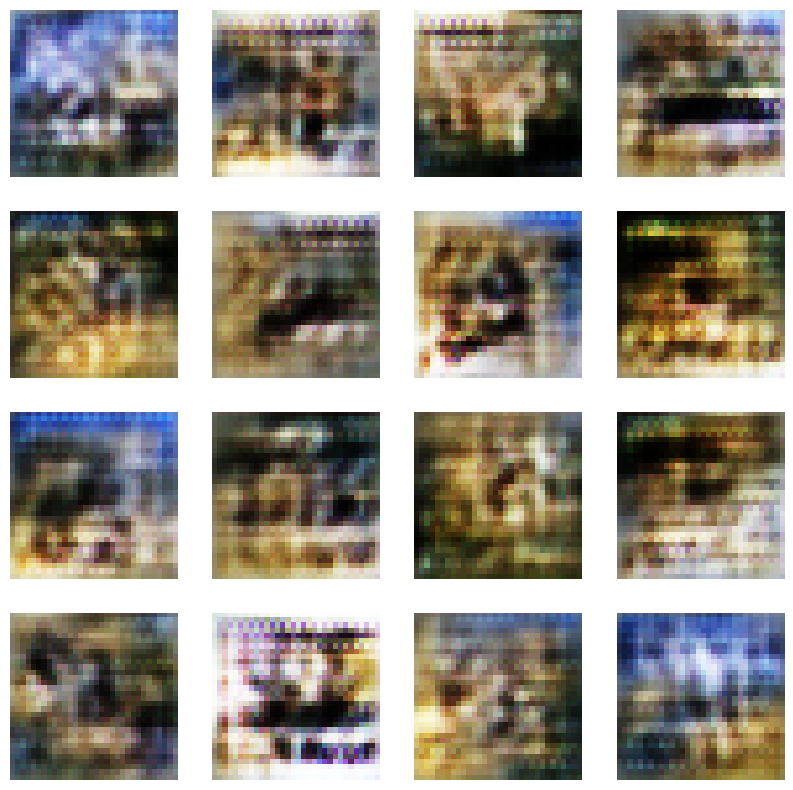

196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - d_loss: 1.1688 - g_loss: 1.1056
Epoch 17/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.1100 - g_loss: 1.2018
Epoch 18/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - d_loss: 1.3972 - g_loss: 1.0215
Epoch 19/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 122ms/step - d_loss: 1.3601 - g_loss: 1.5721
Epoch 20/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - d_loss: 1.3030 - g_loss: 2.0239
Epoch 21/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 1.3722 - g_loss: 1.0989

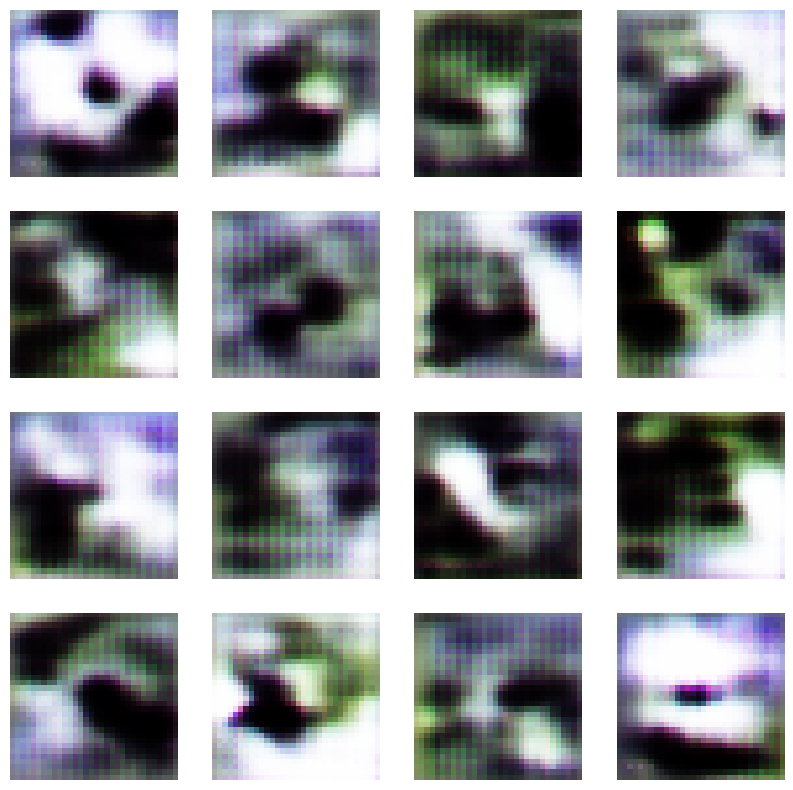

196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - d_loss: 1.3680 - g_loss: 1.1013
Epoch 22/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - d_loss: 0.9454 - g_loss: 1.3117
Epoch 23/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - d_loss: 1.0373 - g_loss: 1.1989
Epoch 24/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - d_loss: 1.0917 - g_loss: 1.1687
Epoch 25/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - d_loss: 1.1393 - g_loss: 1.2234
Epoch 26/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.1538 - g_loss: 1.1549

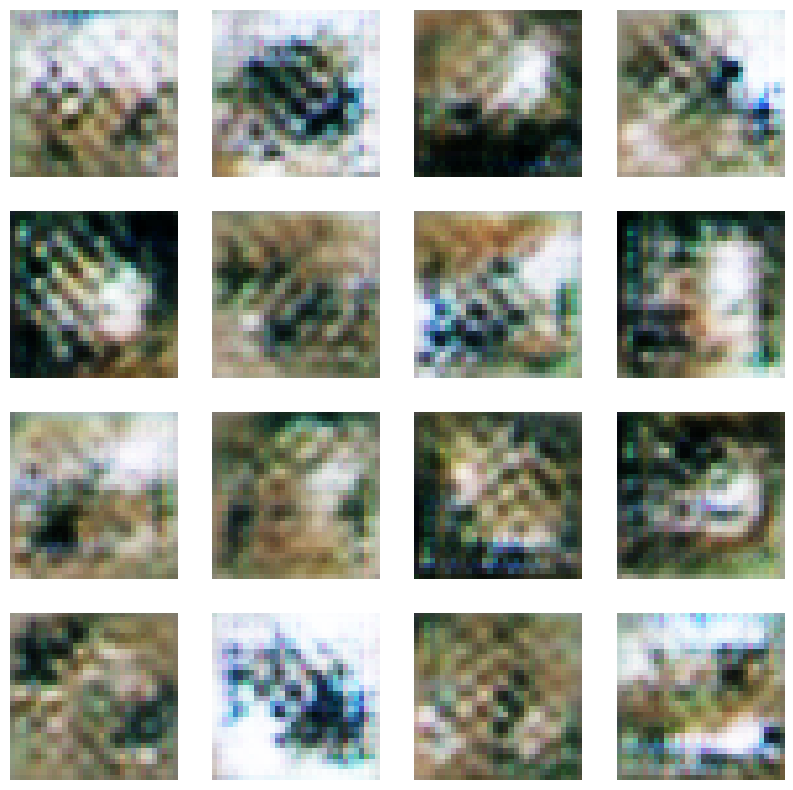

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - d_loss: 1.1535 - g_loss: 1.1541
Epoch 27/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - d_loss: 1.0258 - g_loss: 1.2092
Epoch 28/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.1913 - g_loss: 1.1146
Epoch 29/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - d_loss: 1.2396 - g_loss: 1.3670
Epoch 30/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - d_loss: 1.1526 - g_loss: 1.2460
Epoch 31/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 1.0865 - g_loss: 1.2995

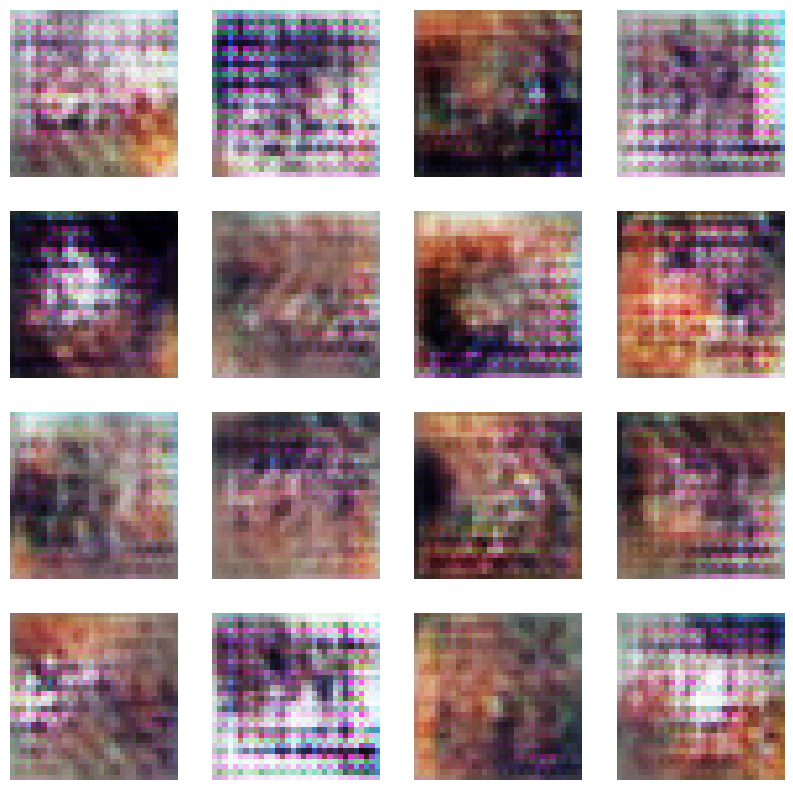

196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 119ms/step - d_loss: 1.0844 - g_loss: 1.3068
Epoch 32/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.3162 - g_loss: 1.4917
Epoch 33/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - d_loss: 1.2490 - g_loss: 1.1064
Epoch 34/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - d_loss: 1.1096 - g_loss: 1.1471
Epoch 35/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - d_loss: 1.1654 - g_loss: 1.2148
Epoch 36/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 1.3007 - g_loss: 1.1581

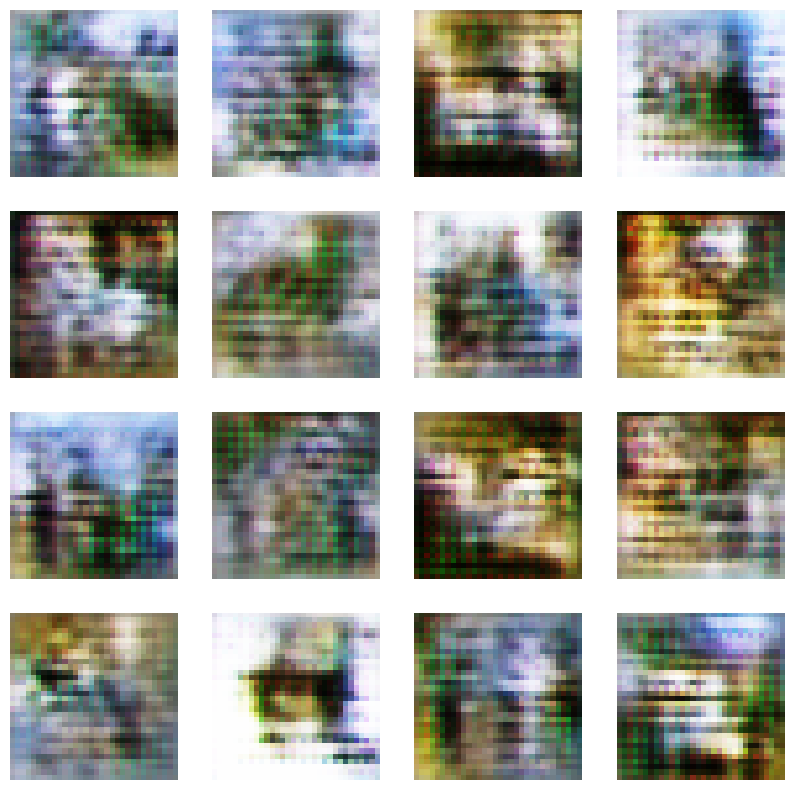

196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - d_loss: 1.2998 - g_loss: 1.1577
Epoch 37/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - d_loss: 1.1173 - g_loss: 1.1866
Epoch 38/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - d_loss: 1.2487 - g_loss: 1.1016
Epoch 39/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - d_loss: 1.2684 - g_loss: 1.1176
Epoch 40/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - d_loss: 1.2584 - g_loss: 1.2842
Epoch 41/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 1.2491 - g_loss: 1.1111

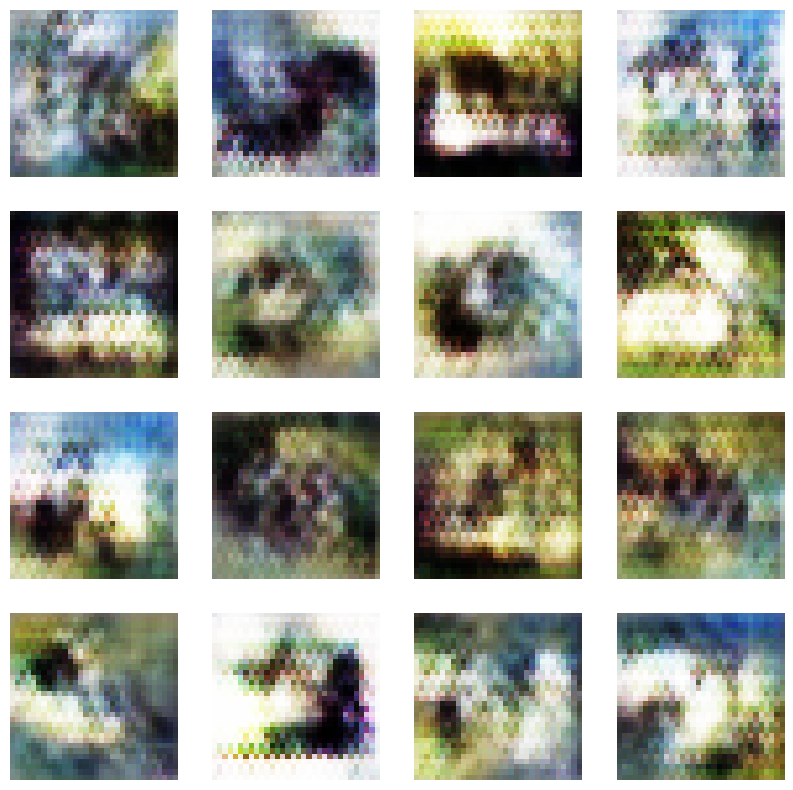

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - d_loss: 1.2455 - g_loss: 1.1158
Epoch 42/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - d_loss: 1.1326 - g_loss: 1.2402
Epoch 43/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.1197 - g_loss: 1.0802
Epoch 44/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - d_loss: 1.1381 - g_loss: 1.0813
Epoch 45/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - d_loss: 1.2852 - g_loss: 1.2422
Epoch 46/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 1.3044 - g_loss: 1.5078

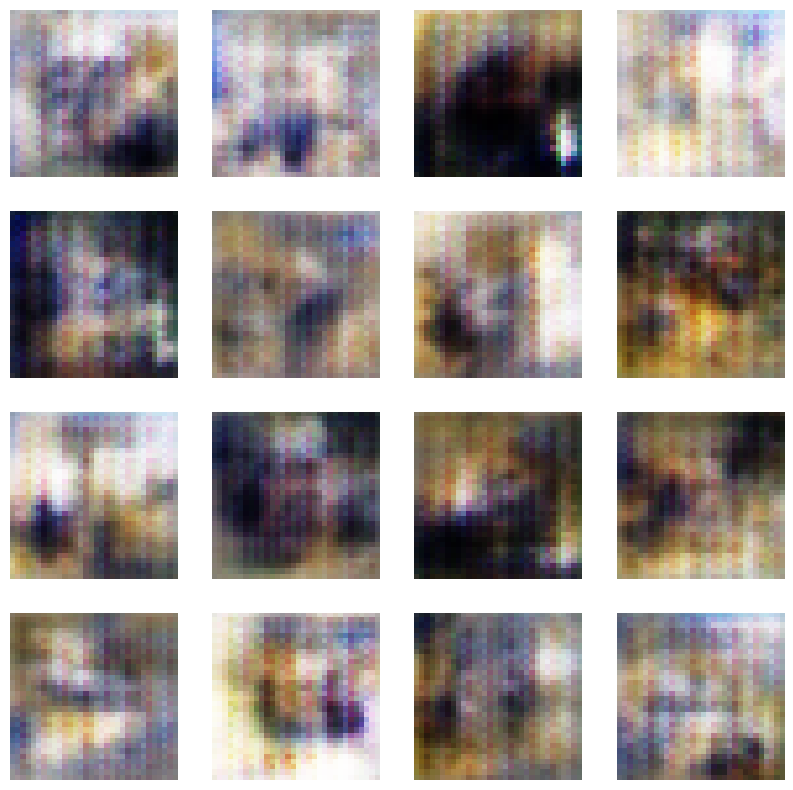

196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - d_loss: 1.3006 - g_loss: 1.5058
Epoch 47/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - d_loss: 1.1312 - g_loss: 1.3597
Epoch 48/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - d_loss: 1.2140 - g_loss: 1.2024
Epoch 49/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - d_loss: 1.1416 - g_loss: 1.0950
Epoch 50/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.1209 - g_loss: 1.1468
Epoch 51/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_loss: 1.1540 - g_loss: 1.0534

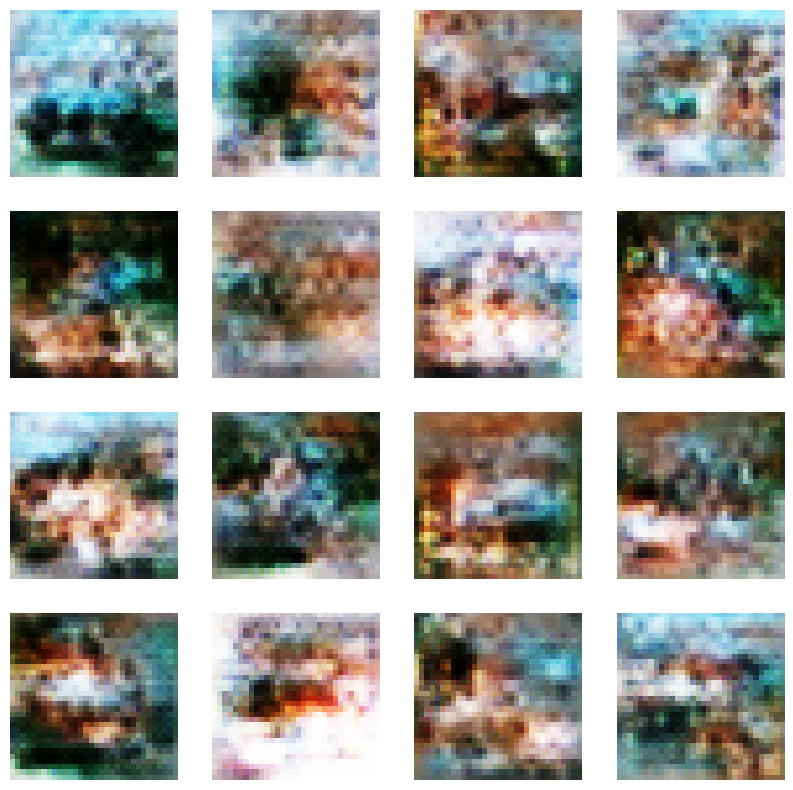

196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - d_loss: 1.1559 - g_loss: 1.0537
Epoch 52/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 121ms/step - d_loss: 1.1144 - g_loss: 1.2106
Epoch 53/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - d_loss: 1.2382 - g_loss: 1.3133
Epoch 54/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - d_loss: 1.2938 - g_loss: 1.1177
Epoch 55/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - d_loss: 1.1869 - g_loss: 1.4034
Epoch 56/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 1.2593 - g_loss: 1.1254

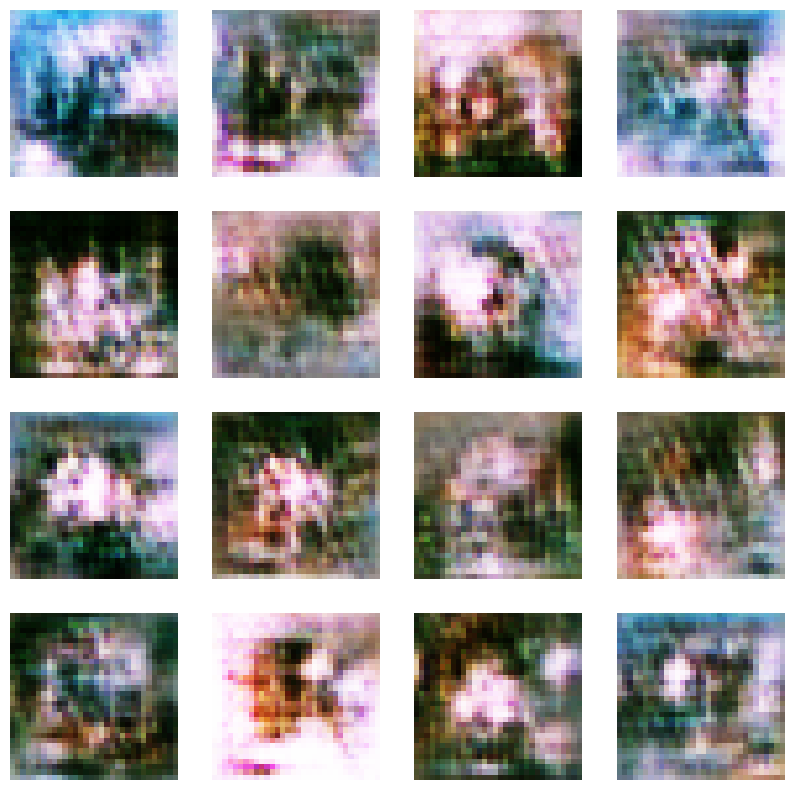

196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - d_loss: 1.2580 - g_loss: 1.1264
Epoch 57/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2482 - g_loss: 1.0505
Epoch 58/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - d_loss: 1.2068 - g_loss: 1.1962
Epoch 59/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - d_loss: 1.2061 - g_loss: 1.1623
Epoch 60/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - d_loss: 1.2733 - g_loss: 1.3418
Epoch 61/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 1.2580 - g_loss: 1.0955

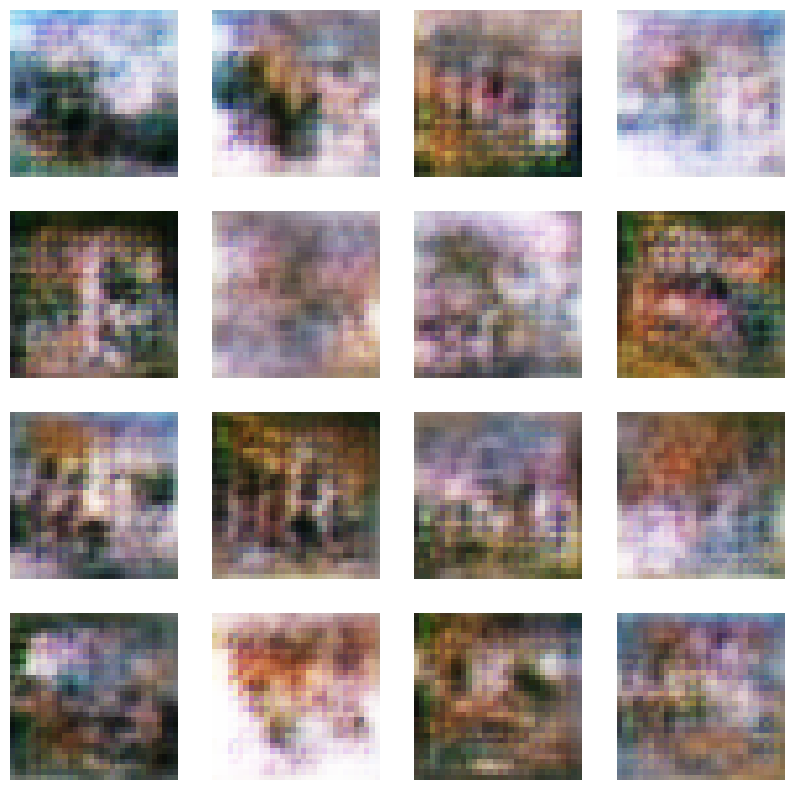

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2600 - g_loss: 1.0944
Epoch 62/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - d_loss: 1.3012 - g_loss: 1.1753
Epoch 63/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2219 - g_loss: 1.0380
Epoch 64/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - d_loss: 1.2301 - g_loss: 1.2297
Epoch 65/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - d_loss: 1.1519 - g_loss: 1.0079
Epoch 66/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 1.1837 - g_loss: 1.1723

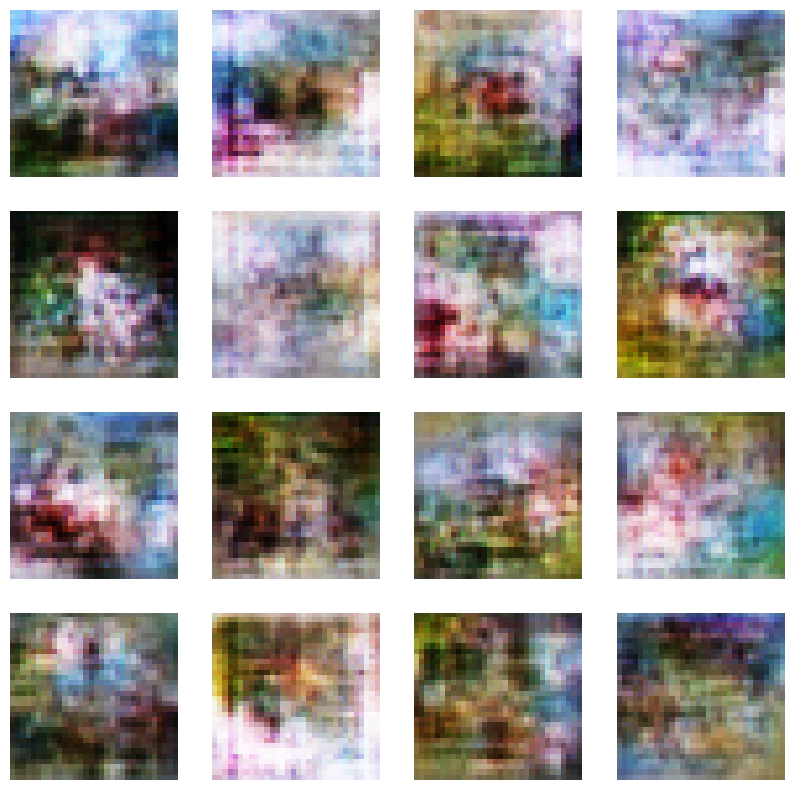

196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - d_loss: 1.1862 - g_loss: 1.1704
Epoch 67/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - d_loss: 1.2466 - g_loss: 1.0308
Epoch 68/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - d_loss: 1.1863 - g_loss: 1.0960
Epoch 69/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - d_loss: 1.2521 - g_loss: 1.1430
Epoch 70/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - d_loss: 1.2547 - g_loss: 1.0669
Epoch 71/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - d_loss: 1.1846 - g_loss: 1.1590

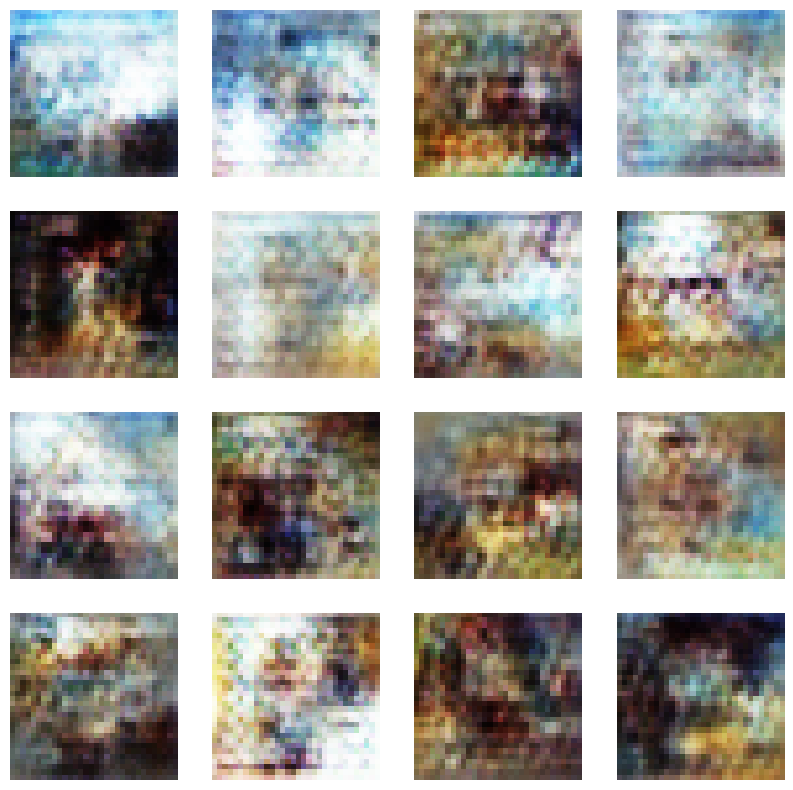

196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - d_loss: 1.1856 - g_loss: 1.1592
Epoch 72/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2713 - g_loss: 1.1041
Epoch 73/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - d_loss: 1.2975 - g_loss: 1.0863
Epoch 74/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - d_loss: 1.2593 - g_loss: 1.2883
Epoch 75/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - d_loss: 1.2119 - g_loss: 1.2227
Epoch 76/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - d_loss: 1.1870 - g_loss: 1.2287

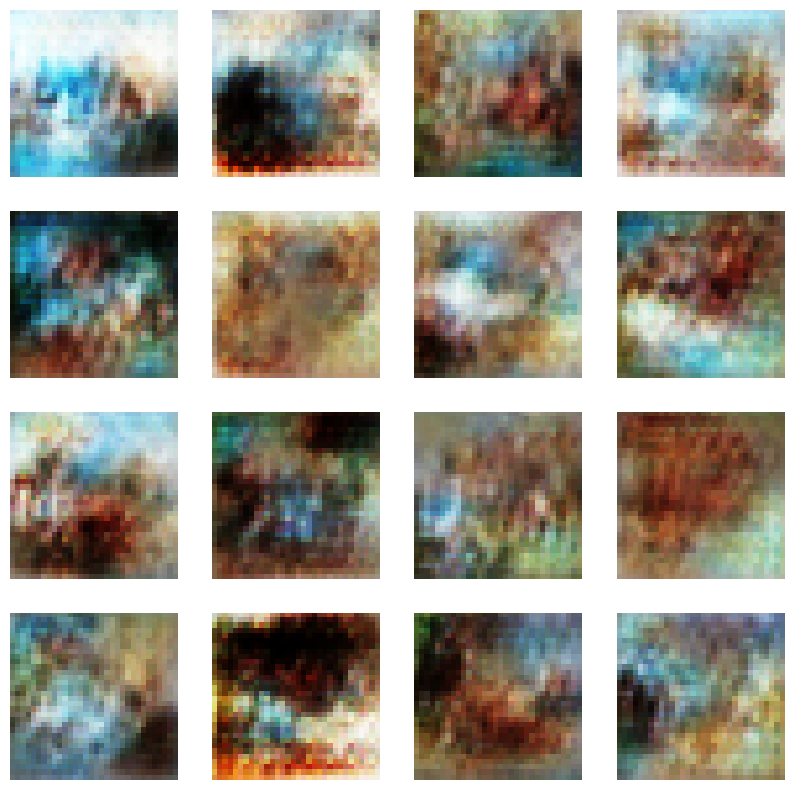

196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - d_loss: 1.1887 - g_loss: 1.2272
Epoch 77/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - d_loss: 1.1184 - g_loss: 1.1690
Epoch 78/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.1964 - g_loss: 1.1666
Epoch 79/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - d_loss: 1.2259 - g_loss: 1.1475
Epoch 80/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2261 - g_loss: 1.1929
Epoch 81/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 1.2812 - g_loss: 1.1203

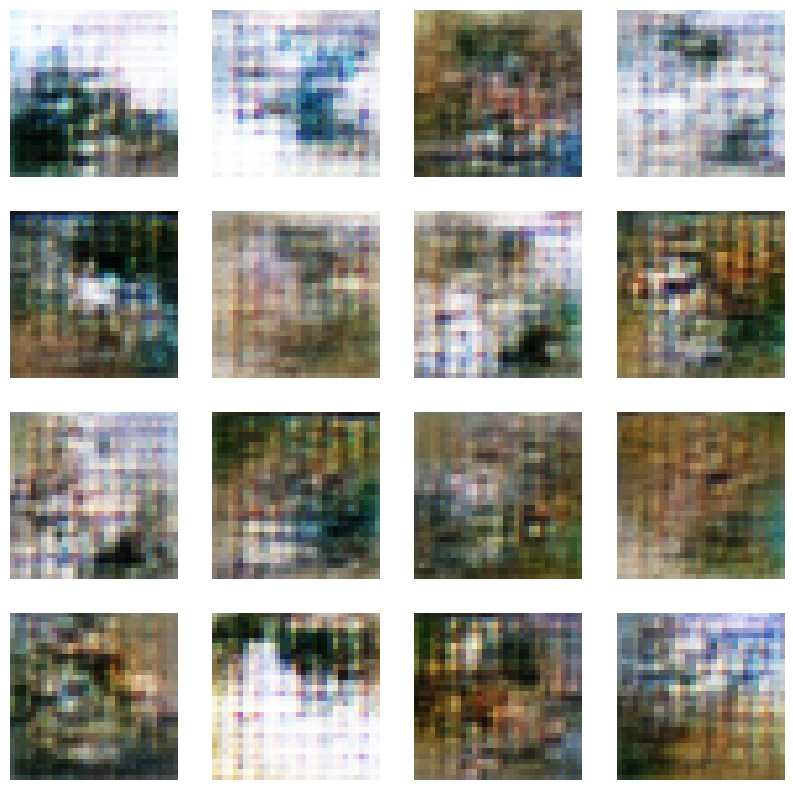

196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - d_loss: 1.2787 - g_loss: 1.1224
Epoch 82/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - d_loss: 1.1282 - g_loss: 1.2674
Epoch 83/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 118ms/step - d_loss: 1.2514 - g_loss: 1.2374
Epoch 84/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - d_loss: 1.1583 - g_loss: 1.0864
Epoch 85/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.2425 - g_loss: 1.1256
Epoch 86/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - d_loss: 1.2177 - g_loss: 1.0839

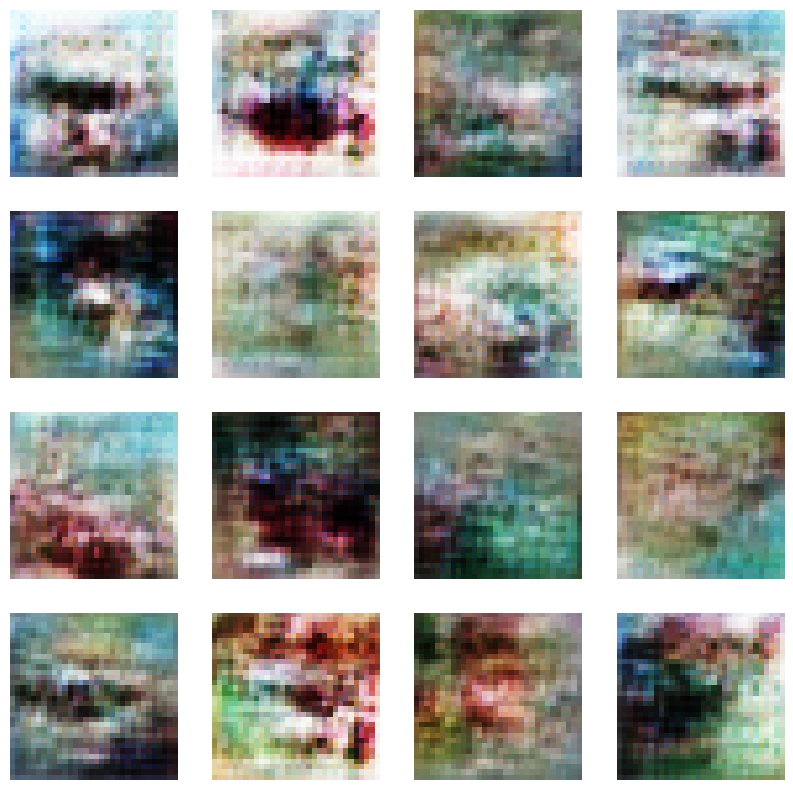

196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 117ms/step - d_loss: 1.2177 - g_loss: 1.0840
Epoch 87/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - d_loss: 1.1805 - g_loss: 1.1701
Epoch 88/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - d_loss: 1.2320 - g_loss: 1.1695
Epoch 89/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - d_loss: 1.2707 - g_loss: 1.1977
Epoch 90/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - d_loss: 1.2462 - g_loss: 1.2552
Epoch 91/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.1506 - g_loss: 1.2214

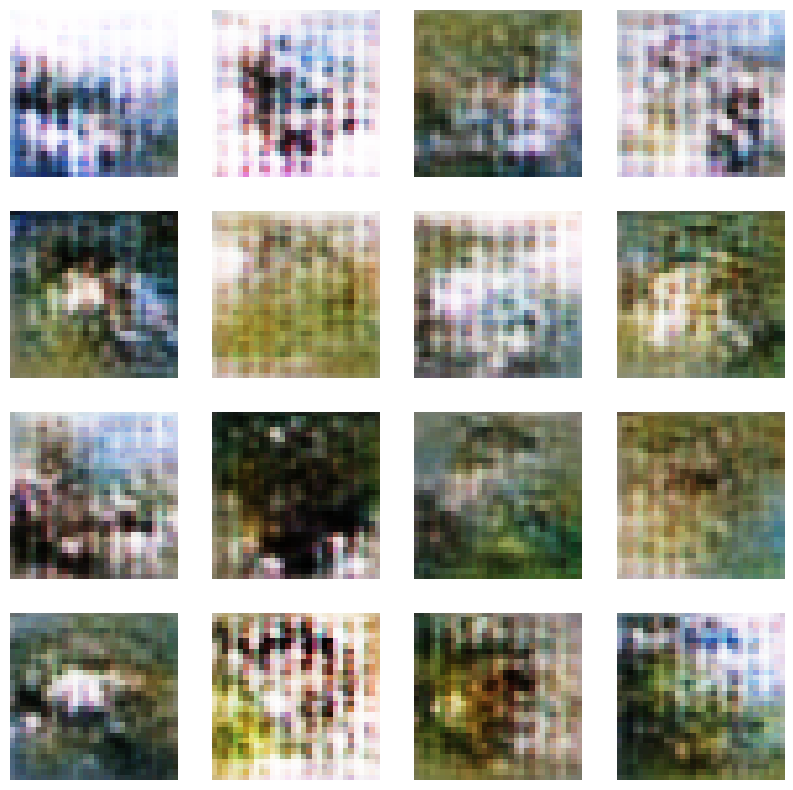

196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - d_loss: 1.1501 - g_loss: 1.2225
Epoch 92/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - d_loss: 1.3113 - g_loss: 1.2310
Epoch 93/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - d_loss: 1.1540 - g_loss: 1.2255
Epoch 94/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - d_loss: 1.2138 - g_loss: 1.1372
Epoch 95/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - d_loss: 1.2361 - g_loss: 1.2190
Epoch 96/100
195/196 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - d_loss: 1.1352 - g_loss: 1.2663

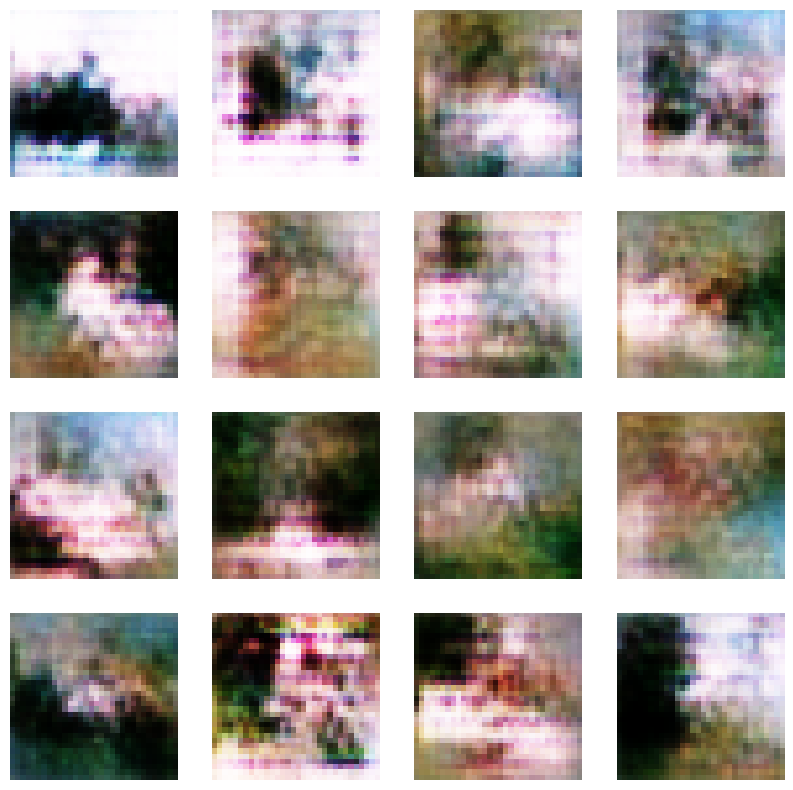

196/196 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - d_loss: 1.1348 - g_loss: 1.2670
Epoch 97/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - d_loss: 1.1730 - g_loss: 1.2070
Epoch 98/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - d_loss: 1.1691 - g_loss: 1.1858
Epoch 99/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - d_loss: 1.1399 - g_loss: 1.1998
Epoch 100/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - d_loss: 1.2249 - g_loss: 1.1273


In [27]:
history = gan.fit(train_data, epochs=EPOCH, callbacks=[ImageCallback()])

# Evaluate the model

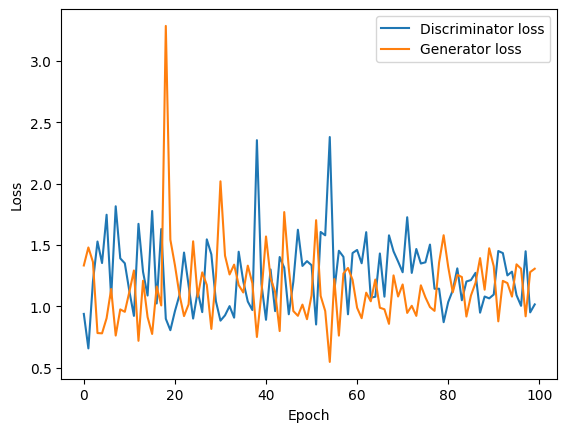

In [28]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5 # denormalize

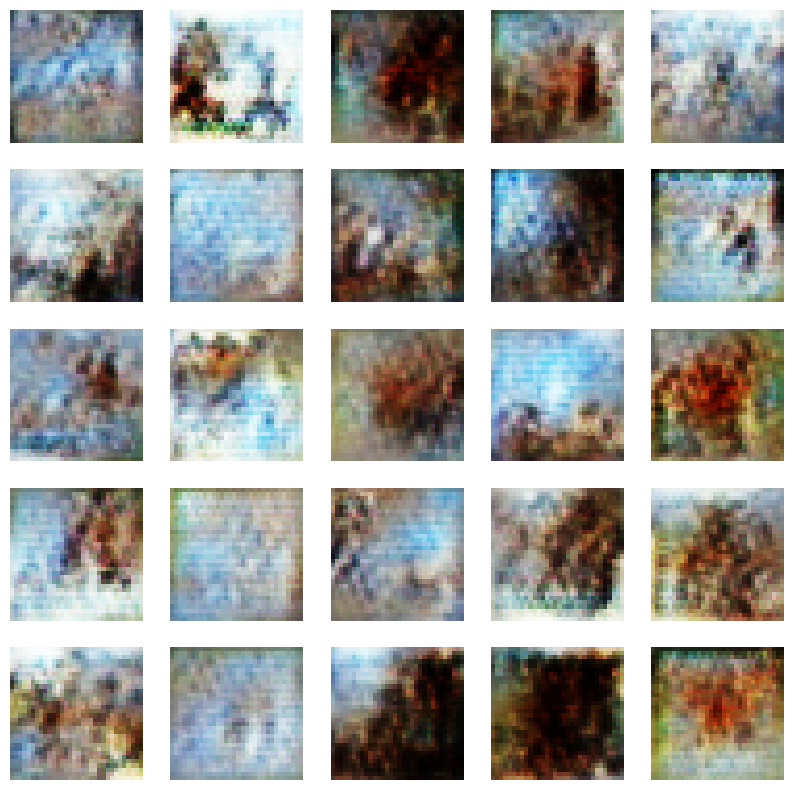

In [33]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
plt.show()

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
generator.save("/content/drive/My Drive/gan_ciphar10_generator.h5")